# ACSE-8
## Coursework 2 - Training a classifier on CIFAR10

You task in this coursework is to implement, train and validate a classifier on the CIFAR10 dataset.  
You are free to use the code provided previously in the classroom exercises - but that code will need to be adapted to work on CIFAR10. 

Complete the following tasks:

1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset. (1 point)
2. Plot 25 images of the training set together with their corresponding label names. (1 point)
3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```  (1 point)
4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data. (1 point)
5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10. (3 points)
6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules (5 points).
  - Other Hyperparameters:
    - Random Number Seed 42
    - Learning Rate = 1e-2
    - Momentum = 0.5
    - Batch Size = 64
    - Test Batch Size = 1000
    - Number of Epochs = 30
    - Optimizer = SGD
 - Values of weight_decay to use in line search: ```[0.0, 1e-3, 1e-4, 1e-5]```
7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set (2 points).
8. Test your final model on the test set and store the model parameters in a ```.pth``` file (2 points).
9. Answer the following questions (1 point each):   
  **Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?   **
  - Left-Right Flips
  - Random Rotations by up to 10 Degrees
  - Up-Down Flips
  - Shifting up-down, left-right by 5 pixels
  - Contrast Changes
  - Adding Gaussian Noise
  - Random Rotations by up to 90 Degrees

10. Bonus: Once you are certain you have achieved all points in the above excercise!
  - Use data-augmentation to train a CIFAR10 classifier using your best value of weight-decay and the other given hyperparameters. (4 points)
  - Use a different classifier (not LeNet-5) to beat your best classification accuracy with LeNet. (3 points)
  
 Describe your working as comments in a Jupyter Notebook together with your code implementation and provide the final Jupyter Notebook and your trained model weights in a github repository.
 
 Total Points: 23 (+7 Bonus Points)

In [6]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 542kB 7.1MB/s 
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [8]:
# Mounting the google drive for later storage
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


1. Use ```torchvision.datasets.CIFAR10``` to load the CIFAR10 dataset. (1 point)


In [218]:
from torchvision.datasets import CIFAR10 

cifar10_train = CIFAR10("./", download=True, train=True)
cifar10_test = CIFAR10("./", download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


2. Plot 25 images of the training set together with their corresponding label names. (1 point)

In [ ]:
def print_pro(name, data_, targets_):
  print(name, ' type: ', type(data_))
  print(name, ' target: ', type(targets_))
  print(name, ' shape: ', data_.shape)

In [220]:
print_pro('train', cifar10_train.data, cifar10_train.targets)
print_pro('test', cifar10_test.data, cifar10_test.targets)

train  type:  <class 'numpy.ndarray'>
train  target:  <class 'list'>
train  shape:  (50000, 32, 32, 3)
test  type:  <class 'numpy.ndarray'>
test  target:  <class 'list'>
test  shape:  (10000, 32, 32, 3)


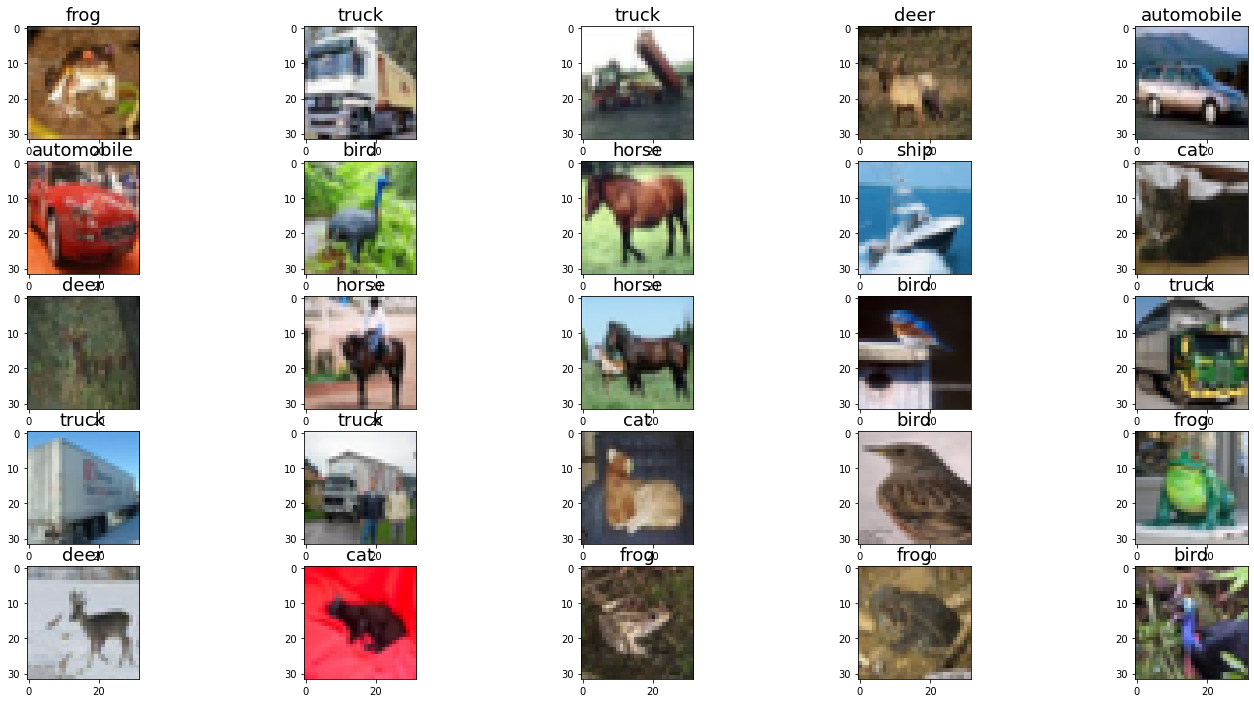

In [9]:
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, features, targets in zip(axarr.flatten(), cifar10_train.data[:25], cifar10_train.targets[:25]):
  ax.imshow(features)
  ax.set_title(cifar10_train.classes[targets], fontsize=18)


3. Create a (90-10) training and validation split using ```sklearn.model_selection.StratifiedShuffleSplit```  (1 point)

In [221]:
arr_cifar10_train_targets = np.array(cifar10_train.targets)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(cifar10_train.data, arr_cifar10_train_targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

print(indices[0].shape, indices[1].shape)

(45000,) (5000,)


In [222]:
train_features = cifar10_train.data[indices[0]]
train_targets = arr_cifar10_train_targets[indices[0]]

validation_features = cifar10_train.data[indices[1]]
validation_targets = arr_cifar10_train_targets[indices[1]]

print_pro('train', train_features, train_targets)
print_pro('validation', validation_features, validation_targets)

train  type:  <class 'numpy.ndarray'>
train  target:  <class 'numpy.ndarray'>
train  shape:  (45000, 32, 32, 3)
validation  type:  <class 'numpy.ndarray'>
validation  target:  <class 'numpy.ndarray'>
validation  shape:  (5000, 32, 32, 3)


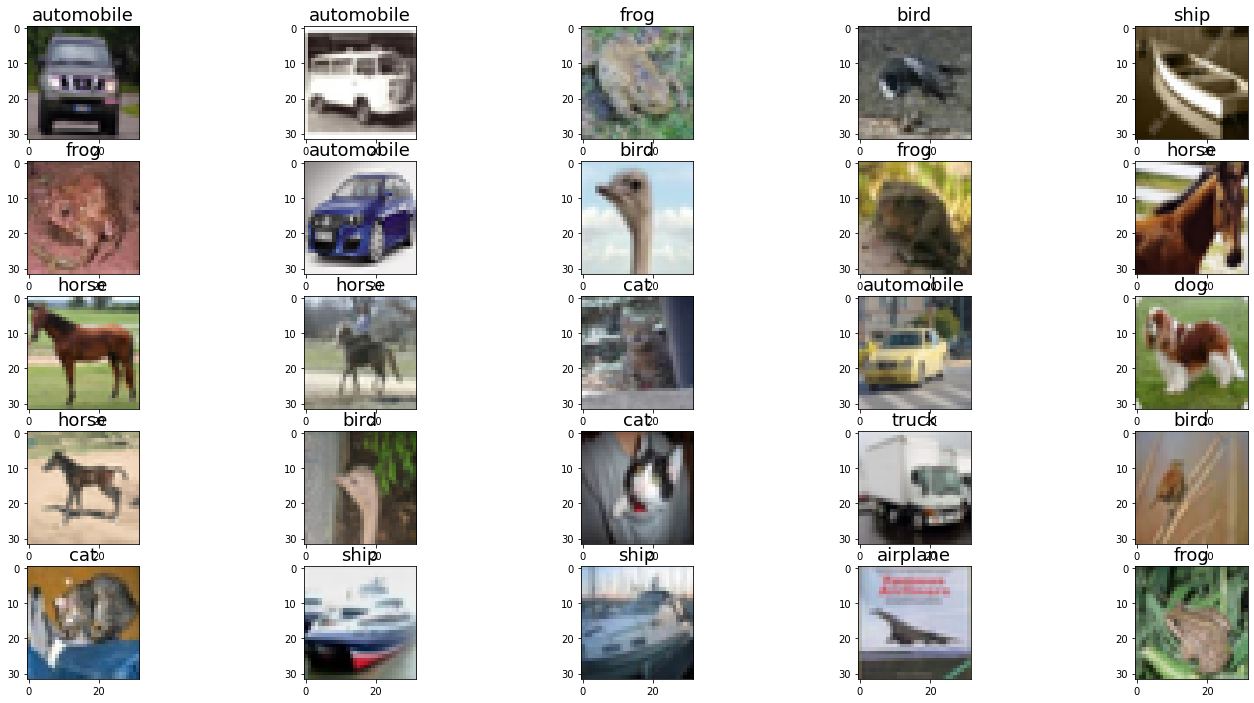

In [73]:
# show first 15 pictures in train, first 5 pictures in validation, and first 5 picture in test
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, features, targets in zip(axarr.flatten(), 
                                 np.vstack((train_features[:15], validation_features[:5], cifar10_test.data[:5])),
                                 np.hstack((train_targets[:15], validation_targets[:5], cifar10_test.targets[:5]))):
  ax.imshow(features)
  ax.set_title(cifar10_train.classes[targets], fontsize=18)

4. Instantiate Datasets and Dataloader with correctly normalized CIFAR10, training, validation and test data. (1 point)

In [223]:
test_features = cifar10_test.data
test_targets = np.array(cifar10_test.targets)

print_pro('train', train_features, train_targets)
print_pro('validation', validation_features, validation_targets)
print_pro('test', test_features, test_targets)

train  type:  <class 'numpy.ndarray'>
train  target:  <class 'numpy.ndarray'>
train  shape:  (45000, 32, 32, 3)
validation  type:  <class 'numpy.ndarray'>
validation  target:  <class 'numpy.ndarray'>
validation  shape:  (5000, 32, 32, 3)
test  type:  <class 'numpy.ndarray'>
test  target:  <class 'numpy.ndarray'>
test  shape:  (10000, 32, 32, 3)


In [ ]:
def convert_tt(features_, targets_):
  # swap features from (sample, dim_x, dim_y, channel) to (sample, channel, dim_x, dim_y)
  features_ = np.swapaxes(features_, 2, 3)
  features_ = np.swapaxes(features_, 1, 2)

  # convert to tourch tensor
  features_ = torch.from_numpy(features_).float()
  targets_ = torch.tensor(targets_).long()
  return features_, targets_

In [225]:
train_features,  train_targets = convert_tt(train_features,  train_targets)
validation_features,  validation_targets = convert_tt(validation_features,  validation_targets)
test_features,  test_targets = convert_tt(test_features,  test_targets)

print_pro('train', train_features, train_targets)
print_pro('validation', validation_features, validation_targets)
print_pro('test', test_features, test_targets)

train  type:  <class 'torch.Tensor'>
train  target:  <class 'torch.Tensor'>
train  shape:  torch.Size([45000, 3, 32, 32])
validation  type:  <class 'torch.Tensor'>
validation  target:  <class 'torch.Tensor'>
validation  shape:  torch.Size([5000, 3, 32, 32])
test  type:  <class 'torch.Tensor'>
test  target:  <class 'torch.Tensor'>
test  shape:  torch.Size([10000, 3, 32, 32])


In [226]:
train_max, train_min = train_features.max(), train_features.min()
print("train max: ", train_max,"\ntrain min: ", train_min)

train max:  tensor(255.) 
train min:  tensor(0.)


In [227]:
# Min-Max normalization
train_features = (train_features-train_min)/(train_max-train_min)
validation_features = (validation_features-train_min)/(train_max-train_min)
test_features = (test_features-train_min)/(train_max-train_min)

print("train max: ", train_features.max(),"\ntrain min: ", train_features.min())
print("validation max: ", validation_features.max(),"\nvalidation min: ", validation_features.min())
print("test max: ", test_features.max(),"\ntest min: ", test_features.min())

train max:  tensor(1.) 
train min:  tensor(0.)
validation max:  tensor(1.) 
validation min:  tensor(0.)
test max:  tensor(1.) 
test min:  tensor(0.)


In [228]:
# calculate mean and std of each channel
means = train_features.mean(dim=(0,2,3))
stds = train_features.std(dim=(0,2,3))
print("means: ", means, "\nstds : ", stds)

means:  tensor([0.4911, 0.4821, 0.4464]) 
stds :  tensor([0.2469, 0.2434, 0.2616])


In [ ]:
# normalization
def apply_normalization(X):
  for i, mean, std in zip(range(3), means, stds):
    X[:, i, :, :] -= mean
    X[:, i, :, :] /= std
  return X

In [230]:
X_train, y_train = apply_normalization(train_features), train_targets
X_val, y_val = apply_normalization(validation_features), validation_targets
X_test, y_test =  apply_normalization(test_features),test_targets

print_pro('train', X_train, y_train)
print_pro('validation', X_val, y_val)
print_pro('test', X_test, y_test)

train  type:  <class 'torch.Tensor'>
train  target:  <class 'torch.Tensor'>
train  shape:  torch.Size([45000, 3, 32, 32])
validation  type:  <class 'torch.Tensor'>
validation  target:  <class 'torch.Tensor'>
validation  shape:  torch.Size([5000, 3, 32, 32])
test  type:  <class 'torch.Tensor'>
test  target:  <class 'torch.Tensor'>
test  shape:  torch.Size([10000, 3, 32, 32])


In [231]:
print("train \n means: ", X_train.mean(dim=(0,2,3)), "\n stds : ",  X_train.std(dim=(0,2,3)), "\n max  :", X_train.max(),"\n min  :", X_train.min())
print("validation \n means: ", X_val.mean(dim=(0,2,3)), "\n stds : ",  X_val.std(dim=(0,2,3)), "\n max  :", X_val.max(),"\n min  :", X_val.min())
print("test \n means: ", X_test.mean(dim=(0,2,3)), "\n stds : ",  X_test.std(dim=(0,2,3)), "\n max  :", X_test.max(),"\n min  :", X_test.min())

train 
 means:  tensor([ 1.1723e-05, -4.9820e-06,  5.9720e-06]) 
 stds :  tensor([1.0000, 1.0000, 1.0000]) 
 max  : tensor(2.1275) 
 min  : tensor(-1.9895)
validation 
 means:  tensor([0.0106, 0.0019, 0.0031]) 
 stds :  tensor([1.0065, 1.0023, 0.9994]) 
 max  : tensor(2.1275) 
 min  : tensor(-1.9895)
test 
 means:  tensor([0.0125, 0.0124, 0.0151]) 
 stds :  tensor([0.9991, 0.9978, 1.0000]) 
 max  : tensor(2.1275) 
 min  : tensor(-1.9895)


In [ ]:
# take first 15 pictures in train, first 5 pictures in validation, and first 5 picture in test
X_train_p, y_train_p = X_train[:15].numpy().copy(), y_train[:15].numpy().copy()
X_val_p, y_val_p = X_val[:5].numpy().copy(), y_val[:5].numpy().copy()
X_test_p, y_test_p = X_test[:5].numpy().copy(), y_test[:5].numpy().copy()

X_stack = np.vstack((X_train_p, X_val_p, X_test_p))
y_stack = np.hstack((y_train_p, y_val_p, y_test_p))

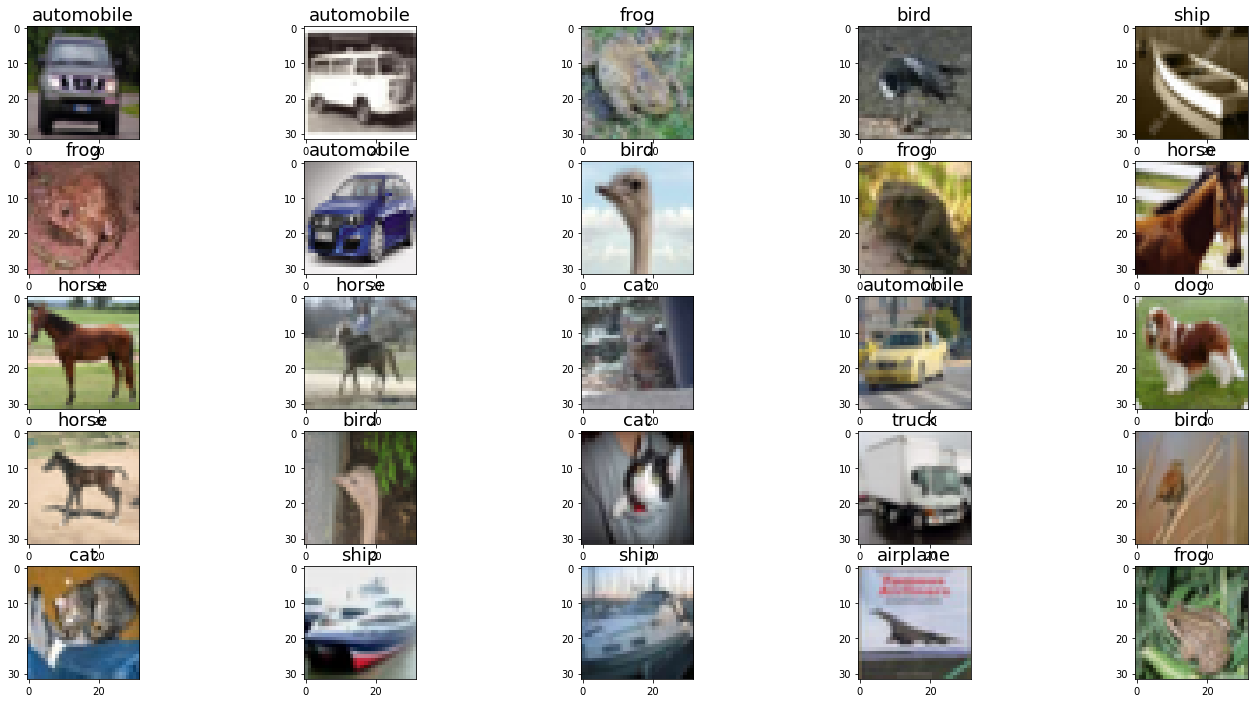

In [23]:
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, features, targets in zip(axarr.flatten(), 
                                 X_stack, 
                                 y_stack):
  #print(features)
  for i, mean, std in zip(range(3), means, stds):
    features[i, :, :] = std * features[i, :, :]
    features[i, :, :] = mean + features[i, :, :]
  features = 255 * features
  features = features.astype(int)
  #print(features)
  ax.imshow(np.transpose(features, (1, 2, 0)))
  ax.set_title(cifar10_train.classes[targets], fontsize=18)

In [ ]:
# dataset
cifar10_train_n = TensorDataset(X_train, y_train)
cifar10_validate_n = TensorDataset(X_val, y_val)
cifar10_test_n = TensorDataset(X_test, y_test)

# Other Hyperparameters:
batch_size = 64
test_batch_size = 1000

# dataloader
train_loader = DataLoader(cifar10_train_n, batch_size=batch_size, shuffle=False, num_workers=0)
validation_loader = DataLoader(cifar10_validate_n, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(cifar10_test_n, batch_size=test_batch_size, shuffle=False, num_workers=0)
  

5. Modify LeNet5 from the morning excercise to be able to work with CIFAR10. (3 points)

In [ ]:
class LeNet5(nn.Module):
  def __init__(self, bias=True):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0, bias=bias)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0, bias=bias)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120, bias=bias)
    self.f6 = nn.Linear(120, 84, bias=bias)
    self.output = nn.Linear(84, 10, bias=bias)
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))  ##returns a "flattened" view of the 2d tensor as inputs for the fully connected layer
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)
  


In [26]:
x = torch.randn((1, 3, 32, 32))
model = LeNet5()
y = model(x)
print(y)

tensor([[ 0.0275, -0.0852, -0.0769, -0.0869, -0.0931, -0.0560, -0.0456,  0.1856,
         -0.0819,  0.0488]], grad_fn=<AddmmBackward>)


6. Perform a line-search over the L2-Regularization parameter, use the ```weight_decay=value``` keyword argument in the ```torch.optim``` modules (5 points).
  - Other Hyperparameters:
    - Random Number Seed 42
    - Learning Rate = 1e-2
    - Momentum = 0.5
    - Batch Size = 64
    - Test Batch Size = 1000
    - Number of Epochs = 30
    - Optimizer = SGD
 - Values of weight_decay to use in line search: ```[0.0, 1e-3, 1e-4, 1e-5]```

In [ ]:
# Other Hyperparameters:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30
weight_decay_list = [0.0, 1e-3, 1e-4, 1e-5]

In [ ]:
  # Provided Train, Validation and Evaluate Functions
  def train(model, optimizer, criterion, data_loader):
      model.train()
      train_loss, train_accuracy = 0, 0
      for X, y in data_loader:
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad()
          a2 = model(X.view(-1, 3, 32, 32))
          loss = criterion(a2, y)
          loss.backward()
          train_loss += loss*X.size(0)
          y_pred = F.log_softmax(a2, dim=1).max(1)[1]
          train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
          optimizer.step()  
          
      return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
    
  def validate(model, criterion, data_loader):
      model.eval()
      validation_loss, validation_accuracy = 0., 0.
      for X, y in data_loader:
          with torch.no_grad():
              X, y = X.to(device), y.to(device)
              a2 = model(X.view(-1, 3, 32, 32))
              loss = criterion(a2, y)
              validation_loss += loss*X.size(0)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
              
      return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
    
  def evaluate(model, data_loader):
      model.eval()
      ys, y_preds = [], []
      for X, y in data_loader:
          with torch.no_grad():
              X, y = X.to(device), y.to(device)
              a2 = model(X.view(-1, 3, 32, 32))
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              ys.append(y.cpu().numpy())
              y_preds.append(y_pred.cpu().numpy())
              
      return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

  def train_model(momentum, weight_decay):
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()
        
    return model




In [ ]:
class train_all():

  def __init__(self, model, optimizer, train_loader, validation_loader, test_loader, 
               criterion, device="cpu"):
    self.model = model
    self.optimizer = optimizer
    self.train_loader = train_loader
    self.validation_loader = validation_loader
    self.test_loader = test_loader
    self.criterion = criterion
    self.device = device
    return

  # Provided Train, Validation and Evaluate Functions
  def train(self):
      self.model.train()
      train_loss, train_accuracy = 0, 0
      for X, y in self.train_loader:
          X, y = X.to(self.device), y.to(self.device)
          self.optimizer.zero_grad()
          a2 = self.model(X.view(-1, 3, 32, 32))
          loss = self.criterion(a2, y)
          loss.backward()
          train_loss += loss*X.size(0)
          y_pred = F.log_softmax(a2, dim=1).max(1)[1]
          train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
          self.optimizer.step()  
          
      return train_loss/len(self.train_loader.dataset), train_accuracy/len(self.train_loader.dataset)
    
  def validate(self):
      if self.validation_loader == None:
        return torch.tensor(0.), torch.tensor(0.)

      self.model.eval()
      validation_loss, validation_accuracy = 0., 0.
      for X, y in self.validation_loader:
          with torch.no_grad():
              X, y = X.to(self.device), y.to(self.device)
              a2 = self.model(X.view(-1, 3, 32, 32))
              loss = self.criterion(a2, y)
              validation_loss += loss*X.size(0)
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
              
      return validation_loss/len(self.validation_loader.dataset), validation_accuracy/len(self.validation_loader.dataset)
    
  def evaluate(self):
      self.model.eval()
      ys, y_preds = [], []
      for X, y in self.test_loader:
          with torch.no_grad():
              X, y = X.to(self.device), y.to(self.device)
              a2 = self.model(X.view(-1, 3, 32, 32))
              y_pred = F.log_softmax(a2, dim=1).max(1)[1]
              ys.append(y.cpu().numpy())
              y_preds.append(y_pred.cpu().numpy())
              
      return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

  def train_model(self, epochs):
      set_seed(seed)
      
      self.liveloss = PlotLosses()
      for epoch in range(epochs):
          logs = {}
          train_loss, train_accuracy = self.train()

          logs['' + 'log loss'] = train_loss.item()
          logs['' + 'accuracy'] = train_accuracy.item()

          validation_loss, validation_accuracy = self.validate()
          logs['val_' + 'log loss'] = validation_loss.item()
          logs['val_' + 'accuracy'] = validation_accuracy.item()

          self.liveloss.update(logs)
          self.liveloss.draw()


  def save_model(self, name, path=F"/content/gdrive/My Drive/models/", only_parameters=False):
        if only_parameters:
            torch.save(self.model.state_dict(), path + name)
        else:
            torch.save(self.model, path + name)
        
        print("Saved to " + path + name)


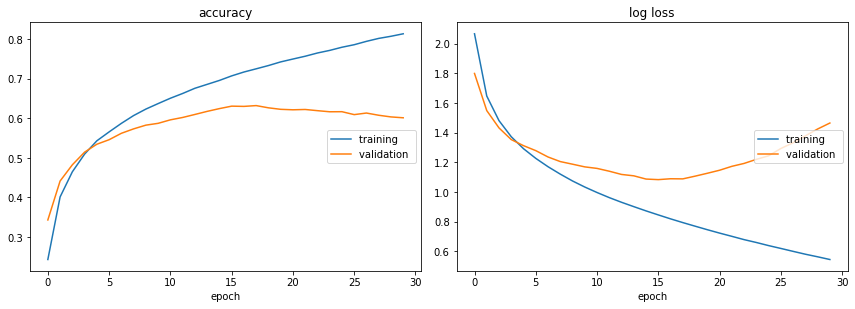

accuracy
	training         	 (min:    0.230, max:    0.817, cur:    0.814)
	validation       	 (min:    0.332, max:    0.653, cur:    0.601)
log loss
	training         	 (min:    0.532, max:    2.107, cur:    0.544)
	validation       	 (min:    1.023, max:    1.861, cur:    1.465)


In [50]:
# weight_decay is 0 
weight_decay = 0.
model_1 = LeNet5().to(device)
optimizer = torch.optim.SGD(model_1.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model1_all = train_all(model_1, optimizer, train_loader, validation_loader, test_loader, criterion, device)
model1_all.train_model(n_epochs)
    

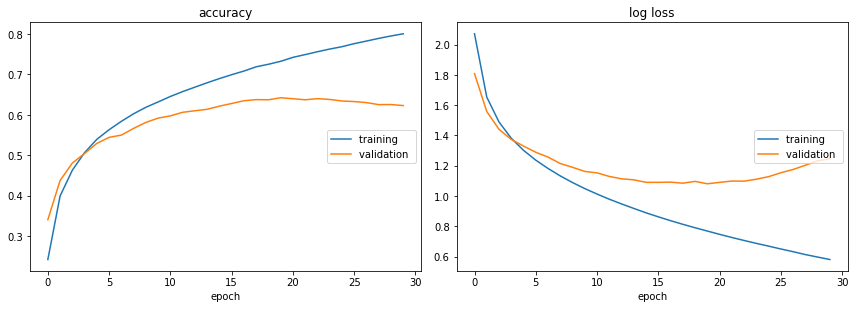

accuracy
	training         	 (min:    0.230, max:    0.817, cur:    0.801)
	validation       	 (min:    0.332, max:    0.653, cur:    0.623)
log loss
	training         	 (min:    0.532, max:    2.107, cur:    0.581)
	validation       	 (min:    1.023, max:    1.861, cur:    1.245)


In [52]:
# weight_decay is 1e-3
weight_decay = 1e-3
model_2 = LeNet5().to(device)
optimizer = torch.optim.SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model2_all = train_all(model_2, optimizer, train_loader, validation_loader, test_loader, criterion, device)
model2_all.train_model(n_epochs)

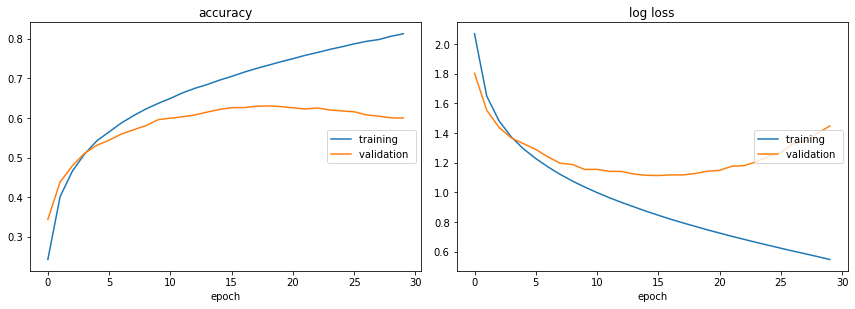

accuracy
	training         	 (min:    0.230, max:    0.817, cur:    0.813)
	validation       	 (min:    0.332, max:    0.653, cur:    0.600)
log loss
	training         	 (min:    0.532, max:    2.107, cur:    0.548)
	validation       	 (min:    1.023, max:    1.861, cur:    1.448)


In [39]:
# weight_decay is 1e-4 
weight_decay = 1e-4
model_3 = LeNet5().to(device)
optimizer = torch.optim.SGD(model_3.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model3_all = train_all(model_3, optimizer, train_loader, validation_loader, test_loader, criterion, device)
model3_all.train_model(n_epochs)

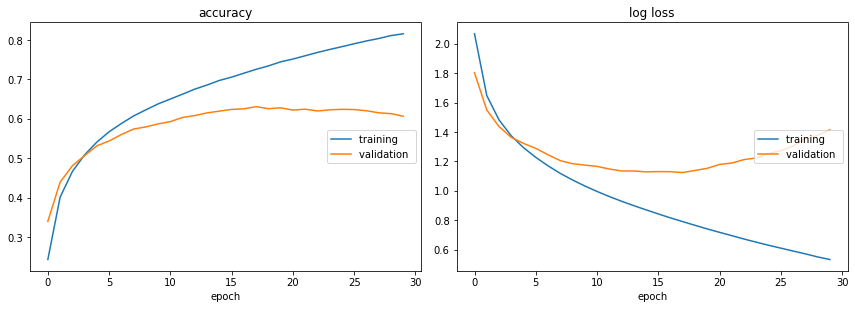

accuracy
	training         	 (min:    0.230, max:    0.817, cur:    0.816)
	validation       	 (min:    0.332, max:    0.653, cur:    0.607)
log loss
	training         	 (min:    0.532, max:    2.107, cur:    0.533)
	validation       	 (min:    1.023, max:    1.861, cur:    1.415)


In [40]:
# weight_decay is 1e-5
weight_decay = 1e-5
model_4 = LeNet5().to(device)
optimizer = torch.optim.SGD(model_4.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model4_all = train_all(model_4, optimizer, train_loader, validation_loader, test_loader, criterion, device)
model4_all.train_model(n_epochs)

In [51]:
weight_decay_list = [0.0, 1e-3, 1e-4, 1e-5]
trian_cur = [0.802, 0.801, 0.813, 0.816]
validation_cur = [0.608, 0.623, 0.600, 0.607]

# print them in a table
print("Decay \t| train accuracy (%)| validation accuracy (%)", "\n-------------------------------------------")
for acc1, acc2, w_decay in zip(trian_cur, validation_cur, weight_decay_list):
    print(w_decay, "\t| %.2f             | %.2f" % (acc1*100, acc2*100))

Decay 	| train accuracy (%)| validation accuracy (%) 
-------------------------------------------
0.0 	| 80.20             | 60.80
0.001 	| 80.10             | 62.30
0.0001 	| 81.30             | 60.00
1e-05 	| 81.60             | 60.70


7. Choose the best weight-decay value given the other hyperparameters and train on the full CIFAR10 training set (2 points).

In [237]:
# merge train data and validation data together to get full traning set
print_pro('train', X_train, y_train)
print_pro('validation', X_val, y_val)

X_train_full = torch.cat((X_train,X_val), 0)
y_train_full = torch.cat((y_train,y_val), 0)

print("\n")
print_pro('train', X_train_full, y_train_full)

train  type:  <class 'torch.Tensor'>
train  target:  <class 'torch.Tensor'>
train  shape:  torch.Size([45000, 3, 32, 32])
validation  type:  <class 'torch.Tensor'>
validation  target:  <class 'torch.Tensor'>
validation  shape:  torch.Size([5000, 3, 32, 32])


train  type:  <class 'torch.Tensor'>
train  target:  <class 'torch.Tensor'>
train  shape:  torch.Size([50000, 3, 32, 32])


In [ ]:
cifar10_train_full = TensorDataset(X_train_full, y_train_full)
train_loader_full = DataLoader(cifar10_train_full, batch_size=batch_size, shuffle=True, num_workers=0)


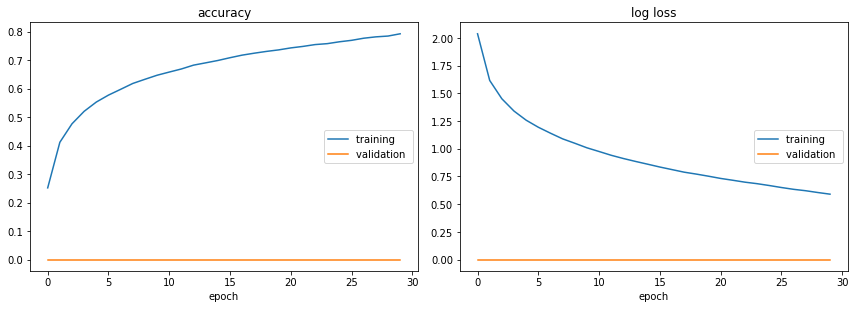

accuracy
	training         	 (min:    0.230, max:    0.817, cur:    0.793)
	validation       	 (min:    0.000, max:    0.653, cur:    0.000)
log loss
	training         	 (min:    0.532, max:    2.107, cur:    0.590)
	validation       	 (min:    0.000, max:    1.861, cur:    0.000)


In [55]:
# 
weight_decay = 1e-3
model_best = LeNet5().to(device)
optimizer = torch.optim.SGD(model_best.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

modelB_all = train_all(model_best, optimizer, train_loader_full, None, test_loader, criterion, device)
modelB_all.train_model(n_epochs)

In [235]:
# download and do the above steps again
cifar10_train = CIFAR10("./", download=True, train=True)
train_features = cifar10_train.data
train_targets = np.array(cifar10_train.targets)
train_features,  train_targets = convert_tt(train_features,  train_targets)
train_features = (train_features-train_min)/(train_max-train_min)
X_train_full, y_train_full = apply_normalization(train_features), train_targets

print_pro('train', X_train_full, y_train_full)

cifar10_train_full = TensorDataset(X_train_full, y_train_full)
train_loader_full = DataLoader(cifar10_train_full, batch_size=batch_size, shuffle=True, num_workers=0)



Files already downloaded and verified
train  type:  <class 'torch.Tensor'>
train  target:  <class 'torch.Tensor'>
train  shape:  torch.Size([50000, 3, 32, 32])


8. Test your final model on the test set and store the model parameters in a ```.pth``` file (2 points).

In [56]:
# run test set to calculate accuracy score
predion, actual = modelB_all.evaluate()

acc = accuracy_score(predion, actual) * 100
print("Accuracy: %.2f" % acc,"%")

Accuracy: 63.98 %


In [57]:
# save model parameters
modelB_all.save_model(name="LeNet5_CIFAR10_classifier.pth", only_parameters=False)

Saved to /content/gdrive/My Drive/models/LeNet5_CIFAR10_classifier.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNet5. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


9. Answer the following questions (1 point each):   
  **Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why?   **
  - Left-Right Flips
  - Random Rotations by up to 10 Degrees
  - Up-Down Flips
  - Shifting up-down, left-right by 5 pixels
  - Contrast Changes
  - Adding Gaussian Noise
  - Random Rotations by up to 90 Degrees


10. Bonus: Once you are certain you have achieved all points in the above excercise!
  - 10.1 Use data-augmentation to train a CIFAR10 classifier using your best value of weight-decay and the other given hyperparameters. (4 points)


In [ ]:
from torch.utils.data import Dataset 

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        print(sample.data.shape)
        print(type(sample.data))
        #sample = sample.view(32, 32, 3).float()/255.
        #sample = sample.float()/255.

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

In [166]:
# we get mean and std of each channel before
means_np, stds_np = means.numpy(), stds.numpy()
print("means: ", means_np, "\nstds : ", stds_np)

means:  [0.49113446 0.4821124  0.44644743] 
stds :  [0.24686915 0.24343014 0.2616034 ]


In [ ]:
#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform = Compose([

    RandomRotation(10),
    ToTensor(),
    Normalize(mean=means_np, std=stds_np), 

]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

#In Validation and Test Mode we only want to normalize our images, because they are already tensors
test_transform = Compose([
              
    ToTensor(),                    
    Normalize(mean=means_np, std=stds_np)
])

In [211]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets,transforms   
import torchvision.transforms as transforms

train_data_augmt = datasets.CIFAR10(root='./',train=True,download=True,transform=train_transform)  
test_data_augmt = datasets.CIFAR10(root='./',train=False,download=True,transform=test_transform)  
train_loader_augmt = torch.utils.data.DataLoader(dataset=train_data_augmt,batch_size=batch_size,shuffle=False)  
test_loader_augmt = torch.utils.data.DataLoader(dataset=test_data_augmt,batch_size=test_batch_size,shuffle=False) 

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_features_augmt,train_targets_augm = iter(train_loader_augmt).next()

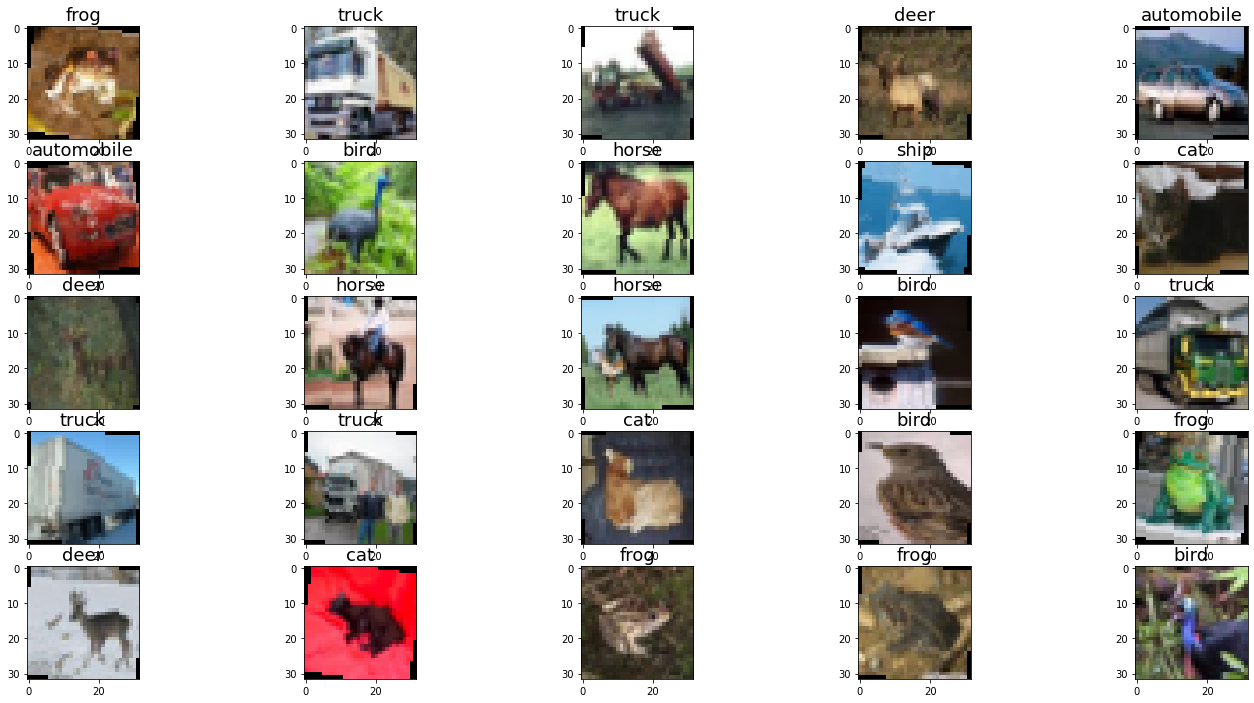

In [213]:
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, features, targets in zip(axarr.flatten(), 
                                 train_features_augmt[:25], 
                                 train_targets_augm[:25]):
  #print(features)
  features = features.numpy()
  for i, mean, std in zip(range(3), means, stds):
    features[i, :, :] = std * features[i, :, :]
    features[i, :, :] = mean + features[i, :, :]
  features = 255 * features
  features = features.astype(int)
  #print(features)
  ax.imshow(np.transpose(features, (1, 2, 0)))
  ax.set_title(cifar10_train.classes[targets], fontsize=18)

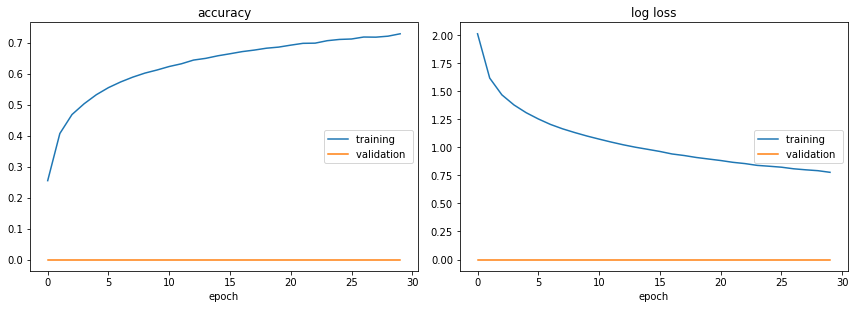

accuracy
	training         	 (min:    0.239, max:    0.729, cur:    0.729)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
log loss
	training         	 (min:    0.776, max:    2.062, cur:    0.776)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [214]:
# weight_decay is 1e-3
weight_decay = 1e-3
model_augmt = LeNet5().to(device)
optimizer = torch.optim.SGD(model_augmt.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model_augmt_all = train_all(model_augmt, optimizer, train_loader_augmt, None, test_loader_augmt, criterion, device)
model_augmt_all.train_model(n_epochs)

In [216]:
# run test set to calculate accuracy score
predion, actual = model_augmt_all.evaluate()

acc = accuracy_score(predion, actual) * 100
print("Accuracy: %.2f" % acc,"%")

Accuracy: 64.92 %


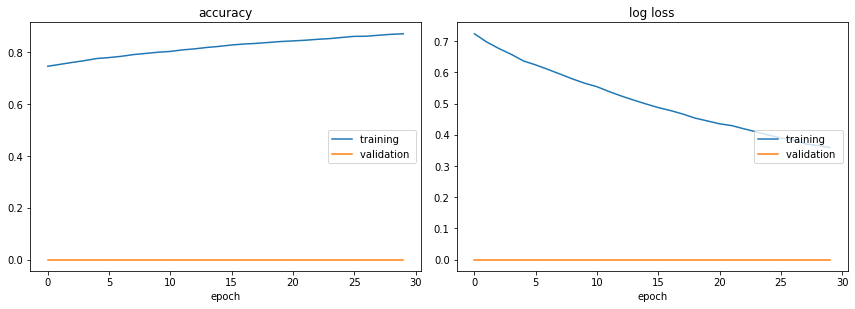

accuracy
	training         	 (min:    0.239, max:    0.872, cur:    0.872)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
log loss
	training         	 (min:    0.359, max:    2.062, cur:    0.359)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [239]:
model_augmt_all = train_all(model_augmt, optimizer, train_loader_full, None, test_loader, criterion, device)
model_augmt_all.train_model(n_epochs)

In [240]:
# run test set to calculate accuracy score
predion, actual = model_augmt_all.evaluate()

acc = accuracy_score(predion, actual) * 100
print("Accuracy: %.2f" % acc,"%")

Accuracy: 63.39 %


In [ ]:
# save model parameters
model_augmt_all.save_model(name="LeNet5_CIFAR10_classifier_with_data_augmentation.pth", only_parameters=False)

In [ ]:
#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform = Compose([
    ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=means_np, std=stds_np), 

]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

#In Validation and Test Mode we only want to normalize our images, because they are already tensors
validation_test_transform = Compose([
    Normalize(mean=means_np, std=stds_np)
])

In [127]:
# Creating the CustomImageTensorDataset
cifar10_train = CIFAR10("./", download=True, train=True)
cifar10_test = CIFAR10("./", download=True, train=False)

arr_cifar10_train_targets_augmt = np.array(cifar10_train.targets)

X_train_augmt, y_train_augmt = cifar10_train.data[indices[0]], arr_cifar10_train_targets_augmt[indices[0]]
X_val_augmt, y_val_augmt = cifar10_train.data[indices[1]], arr_cifar10_train_targets_augmt[indices[1]]
X_test_augmt, y_test_augmt = cifar10_test.data, cifar10_test.targets


Files already downloaded and verified
Files already downloaded and verified


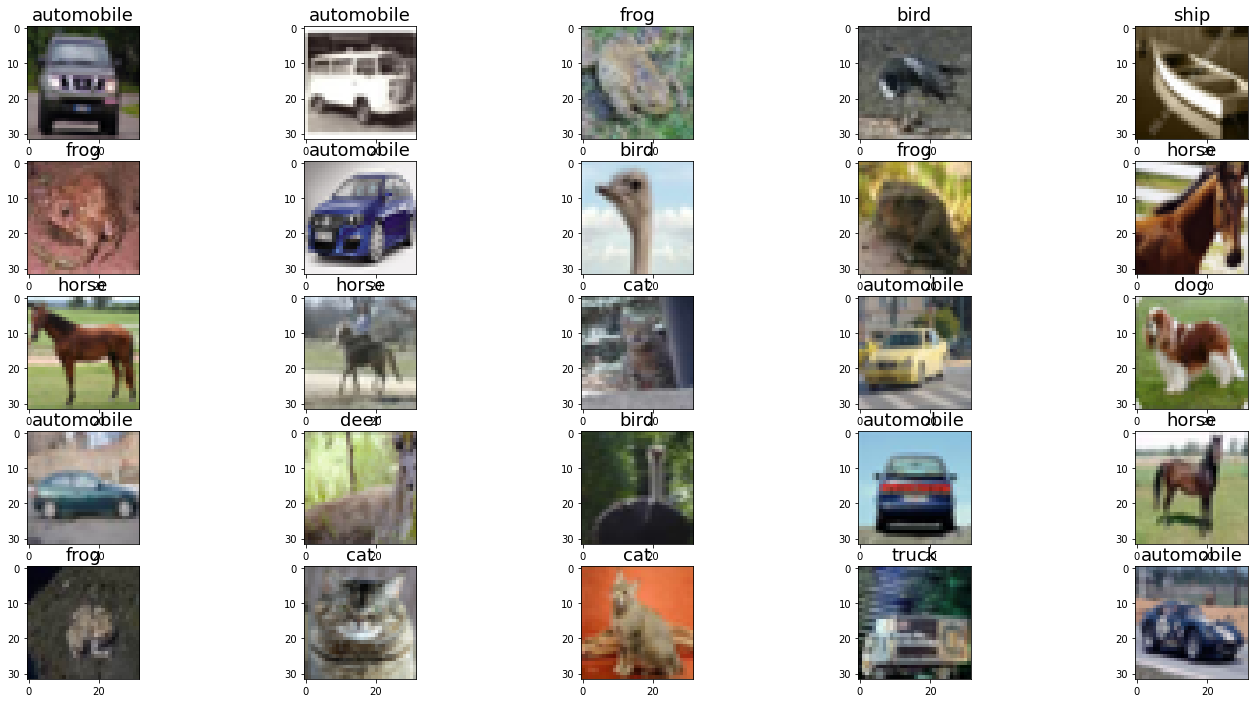

In [128]:
# show first 15 pictures in train, first 5 pictures in validation, and first 5 picture in test
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, features, targets in zip(axarr.flatten(), 
                                 X_train_augmt[:25],
                                 y_train_augmt[:25]):
  ax.imshow(features)
  ax.set_title(cifar10_train.classes[targets], fontsize=18)

In [95]:
# Creating the CustomImageTensorDataset
cifar10_train_augmt =  torchvision.datasets.CIFAR10("./", download=True, train=True, transform=train_transform)
cifar10_test_augmt = torchvision.datasets.CIFAR10("./", download=True, train=False, transform=validation_test_transform)

arr_cifar10_train_targets_augmt = np.array(cifar10_test_augmt.targets)

X_train_augmt, y_train_augmt = cifar10_train_augmt.data[indices[0]], arr_cifar10_train_targets_augmt[indices[0]]
X_val_augmt, y_val_augmt = cifar10_train_augmt.data[indices[1]], arr_cifar10_train_targets_augmt[indices[1]]
X_test_augmt, y_test_augmt = cifar10_test_augmt.data, cifar10_test_augmt.targets

Files already downloaded and verified
Files already downloaded and verified


IndexError: ignored

In [ ]:
custom_cifar10_train_augmt = CustomImageTensorDataset(X_train_augmt, y_train_augmt, transform=train_transform)
cifar10_validation_augmt = CustomImageTensorDataset(X_val_augmt, y_val_augmt, transform=validation_test_transform)
cifar10_test_augmt = CustomImageTensorDataset(X_test_augmt, y_test_augmt, transform=validation_test_transform)


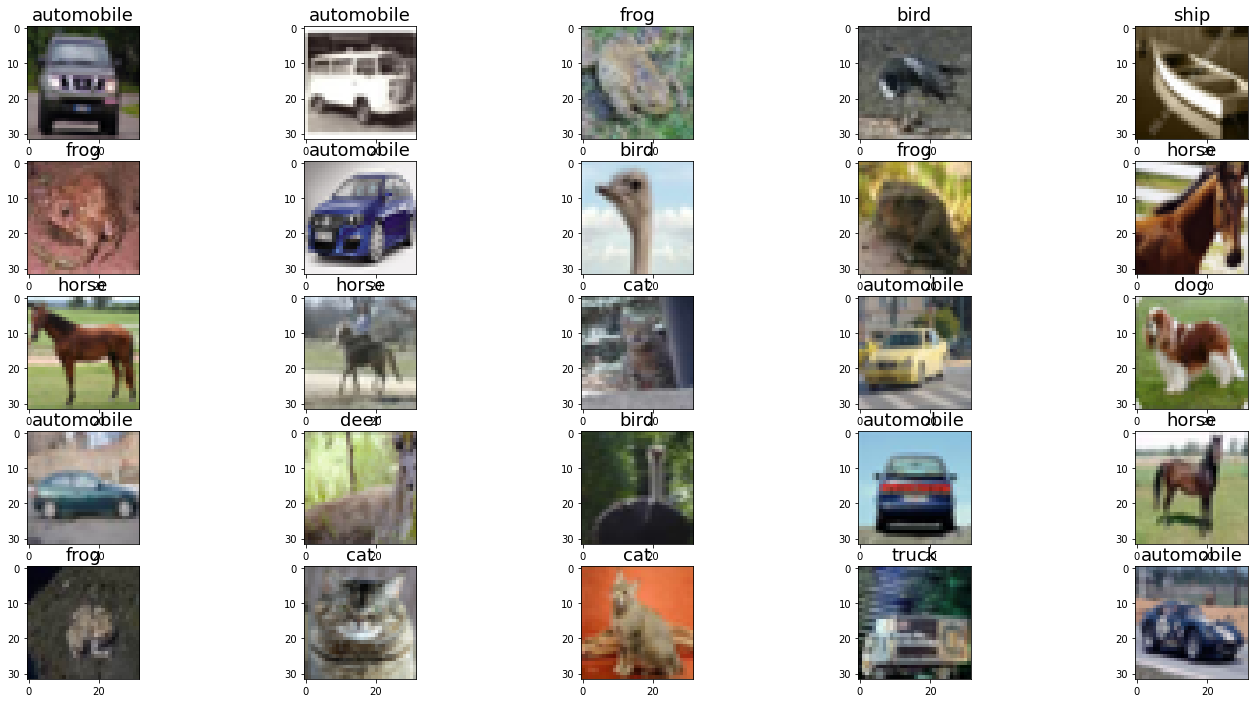

In [134]:
# show first 15 pictures in train, first 5 pictures in validation, and first 5 picture in test
fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
for ax, features, targets in zip(axarr.flatten(), 
                                 custom_cifar10_train_augmt.data[:25],
                                 custom_cifar10_train_augmt.targets[:25]):
  ax.imshow(features)
  ax.set_title(cifar10_train.classes[targets], fontsize=18)

In [165]:
# weight_decay is 1e-3
weight_decay = 1e-3
model_augmt = LeNet5().to(device)
optimizer = torch.optim.SGD(model_augmt.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model_augmt_all = train_all(model_augmt, optimizer, custom_cifar10_train_augmt, cifar10_validation_augmt, cifar10_test_augmt, criterion, device)
model_augmt_all.train_model(n_epochs)

(32, 32, 3)
<class 'memoryview'>


TypeError: ignored

array([[[0.12156863, 0.18431373, 0.08235294],
        [0.11372549, 0.16078431, 0.08627451],
        [0.10588235, 0.11764706, 0.09411765],
        ...,
        [0.05490196, 0.0745098 , 0.05490196],
        [0.05490196, 0.0745098 , 0.05098039],
        [0.06666667, 0.08627451, 0.0627451 ]],

       [[0.15294118, 0.21568627, 0.10196078],
        [0.11372549, 0.14901961, 0.07843137],
        [0.10196078, 0.1254902 , 0.07843137],
        ...,
        [0.06666667, 0.08627451, 0.0627451 ],
        [0.0627451 , 0.08235294, 0.05490196],
        [0.05098039, 0.06666667, 0.04313725]],

       [[0.16078431, 0.22352941, 0.10588235],
        [0.16078431, 0.21568627, 0.10196078],
        [0.11372549, 0.16470588, 0.07058824],
        ...,
        [0.08235294, 0.11372549, 0.07843137],
        [0.0627451 , 0.09411765, 0.05882353],
        [0.0745098 , 0.09019608, 0.06666667]],

       ...,

       [[0.49803922, 0.45490196, 0.43921569],
        [0.49803922, 0.44313725, 0.43137255],
        [0.48235294, 0

In [ ]:
train_loader, validation_loader, test_loader
train_loader_full

  - 10.2 Use a different classifier (not LeNet-5) to beat your best classification accuracy with LeNet. (3 points)

In [ ]:
from tqdm import tqdm
from torch.autograd import Variable

'''Define VGG16'''
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #2
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #3
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #4
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #5
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #6
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #7
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #8
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #9
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #10
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #11
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #12
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #13
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.AvgPool2d(kernel_size=1,stride=1),
            )
        self.classifier = nn.Sequential(
            #14
            nn.Linear(512,4096),
            nn.ReLU(True),
            nn.Dropout(),
            #15
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            #16
            nn.Linear(4096,num_classes),
            )

 
    def forward(self, x):
        out = self.features(x) 
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

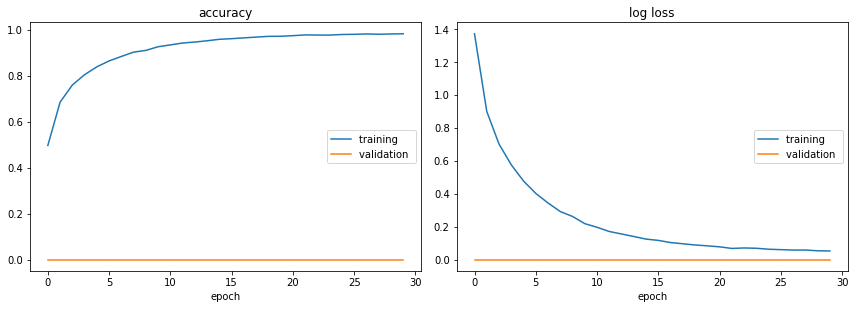

accuracy
	training         	 (min:    0.239, max:    0.982, cur:    0.982)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
log loss
	training         	 (min:    0.052, max:    2.062, cur:    0.052)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [245]:
# weight_decay is 1e-3
weight_decay = 1e-3
model_VGG16 = VGG16().to(device)
optimizer = torch.optim.SGD(model_VGG16.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

model_VGG16_all = train_all(model_VGG16, optimizer, train_loader_augmt, None, test_loader_augmt, criterion, device)
model_VGG16_all.train_model(n_epochs)

In [246]:
# run test set to calculate accuracy score
predion, actual = model_VGG16_all.evaluate()

acc = accuracy_score(predion, actual) * 100
print("Accuracy: %.2f" % acc,"%")

Accuracy: 81.07 %


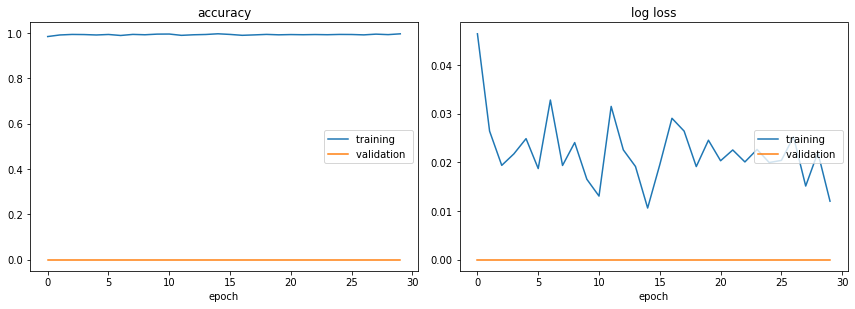

accuracy
	training         	 (min:    0.239, max:    0.997, cur:    0.997)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
log loss
	training         	 (min:    0.011, max:    2.062, cur:    0.012)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [247]:
model_VGG16_all = train_all(model_VGG16, optimizer, train_loader_full, None, test_loader, criterion, device)
model_VGG16_all.train_model(n_epochs)

In [248]:
# run test set to calculate accuracy score
predion, actual = model_VGG16_all.evaluate()

acc = accuracy_score(predion, actual) * 100
print("Accuracy: %.2f" % acc,"%")

Accuracy: 80.23 %


In [ ]:
# save model parameters
model_VGG16_all.save_model(name="VGG16_CIFAR10_classifier_with_data_augmentation.pth", only_parameters=False)